## Email Spam Classifer

- Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import  Counter
import nltk
import pickle
import string


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Importing dataset
# Email_spam = pd.read_csv("D:/kaggle/spam.csv", encoding= 'latin-1')
Email_spam = pd.read_csv("D:/kaggle/spam.csv", encoding= 'latin-1') 

In [3]:
Email_spam.sample(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
40,ham,Pls go ahead with watts. I just wanted to be s...,NaN,NaN,NaN
2183,ham,"Chinatown got porridge, claypot rice, yam cake...",NaN,NaN,NaN
4070,ham,I've reached home n i bathe liao... U can call...,NaN,NaN,NaN


##  Workflow for our current problem:
     - Data cleaning
     - EDA
     - Feature Engineering
     - Text preprocessing
     - Model Builing 
     - Evaluation
     - Improvement

## 1. Data Cleaning

In [4]:
# Email_spam.info()
Email_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
#Dropping unnecessary columns

Email_spam.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace= True)

In [6]:
Email_spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Our Feature and target variable are not descriptive
#convert them to more descriptive form

Email_spam.rename(columns={'v1' : 'Target', 'v2' : 'Text'}, inplace=True)
Email_spam.sample(2)

,Target,Text
4789,ham,Yup. Izzit still raining heavily cos i'm in e ...
3791,ham,Love it! I want to flood that pretty pussy wit...


- Label Encoder

In [8]:
#Encoding the target varible
le = LabelEncoder()
Email_spam['Target'] = le.fit_transform(Email_spam['Target'])

In [9]:
Email_spam.sample(4)

,Target,Text
2700,0,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t..."
1465,1,YOU 07801543489 are guaranteed the latests Nok...
2223,1,"Thanks for your ringtone order, ref number K71..."
3370,0,Tomorrow i am not going to theatre. . . So i c...


In [10]:
#Checking for missing value

Email_spam.isna().sum()

Target    0
Text      0
dtype: int64

In [11]:
#Checking for duplicates
Email_spam.duplicated().sum()

403

In [12]:
# Drop Duplicates
Email_spam.drop_duplicates(keep='first', inplace=True)

In [13]:
Email_spam.shape

(5169, 2)

## 2. EDA

In [14]:
Email_spam.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
#Ham & Spam Counts
Email_spam['Target'].value_counts()

0    4516
1     653
Name: Target, dtype: int64

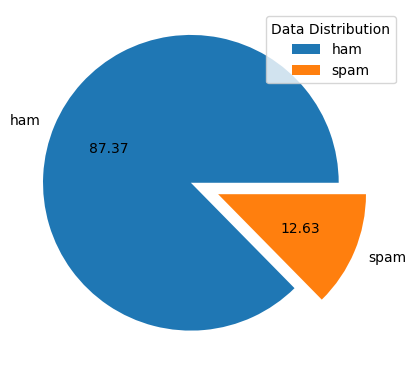

In [16]:
#Ploting pie chart to vizualize distribution of data

plt.pie(Email_spam['Target'].value_counts(), autopct= "%.2f", labels= ['ham', 'spam'], explode=[0.2, 0.0])
plt.legend(title = "Data Distribution", labels= ['ham', 'spam'],  loc = 'upper right')
plt.show()

- Observations:
   1. Data is Imblanced
   2. Having Less Spam Messages in Dataset

## 3. Feature Engineering


Constructing New Features

In [17]:
# Total No. of Characters in Data
Email_spam['Characters'] = Email_spam['Text'].apply(len)

In [18]:
# Total No. of Words in Data
Email_spam['Words'] = Email_spam['Text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [19]:
# Total No. of Sentence in Data
Email_spam['Sentence'] = Email_spam['Text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [20]:
Email_spam.sample(2)

,Target,Text,Characters,Words,Sentence
3018,0,Wat time do u wan 2 meet me later?,34,10,1
4162,0,I told that am coming on wednesday.,35,8,1


In [21]:
# Statistical Analysis of new features
Email_spam[['Characters', 'Words', 'Sentence']].describe()

,Characters,Words,Sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
# Statistical Analysis of HAM data
Email_spam[Email_spam['Target']==0][['Characters', 'Words', 'Sentence']].describe()

,Characters,Words,Sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [23]:
# Statistical Analysis of SPAM data
Email_spam[Email_spam['Target']==1][['Characters', 'Words', 'Sentence']].describe()

,Characters,Words,Sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


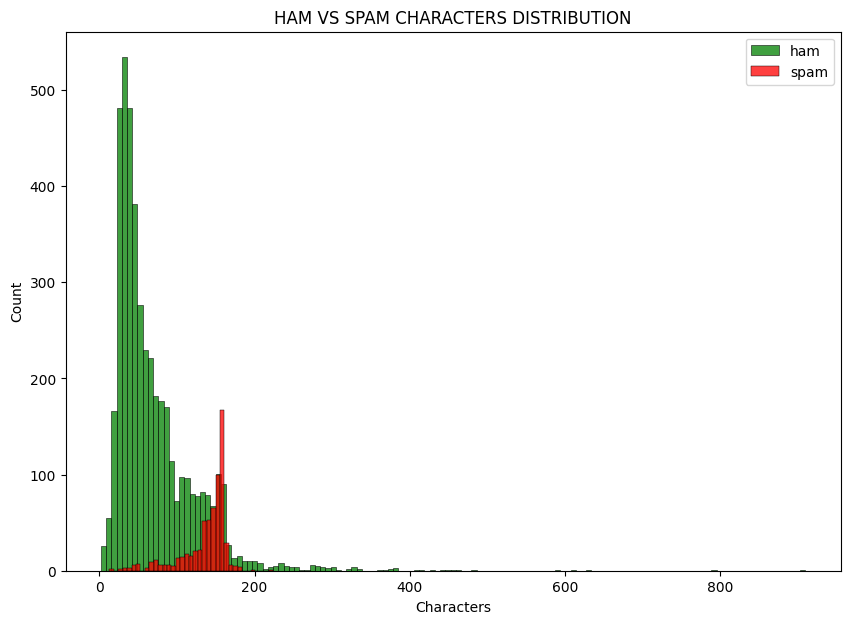

In [24]:
#Vizualize HAM and SPAM distribution for Charcters
plt.figure(figsize=(10,7))
sns.histplot(Email_spam[Email_spam['Target'] ==0]['Characters'], label = 'ham', color = 'green')
sns.histplot(Email_spam[Email_spam['Target'] ==1]['Characters'], label= 'spam', color= 'red')
plt.title("HAM VS SPAM CHARACTERS DISTRIBUTION")
plt.legend()
plt.show()

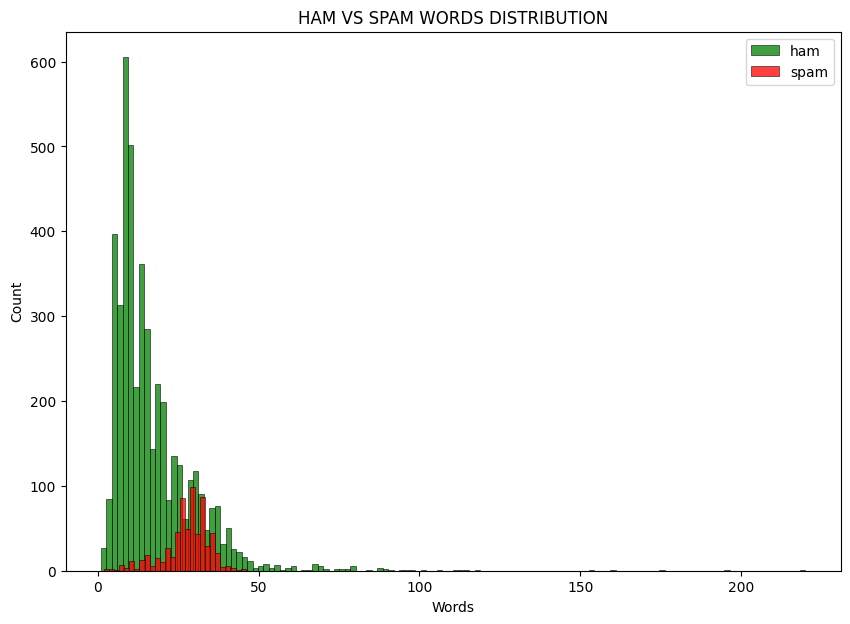

In [25]:
#Vizualize HAM and SPAM distribution for Charcters
plt.figure(figsize=(10,7))
sns.histplot(Email_spam[Email_spam['Target'] == 0]['Words'], label = 'ham', color = 'green')
sns.histplot(Email_spam[Email_spam['Target'] == 1]['Words'], label = 'spam', color = 'red')
plt.title("HAM VS SPAM WORDS DISTRIBUTION")
plt.legend()
plt.show()

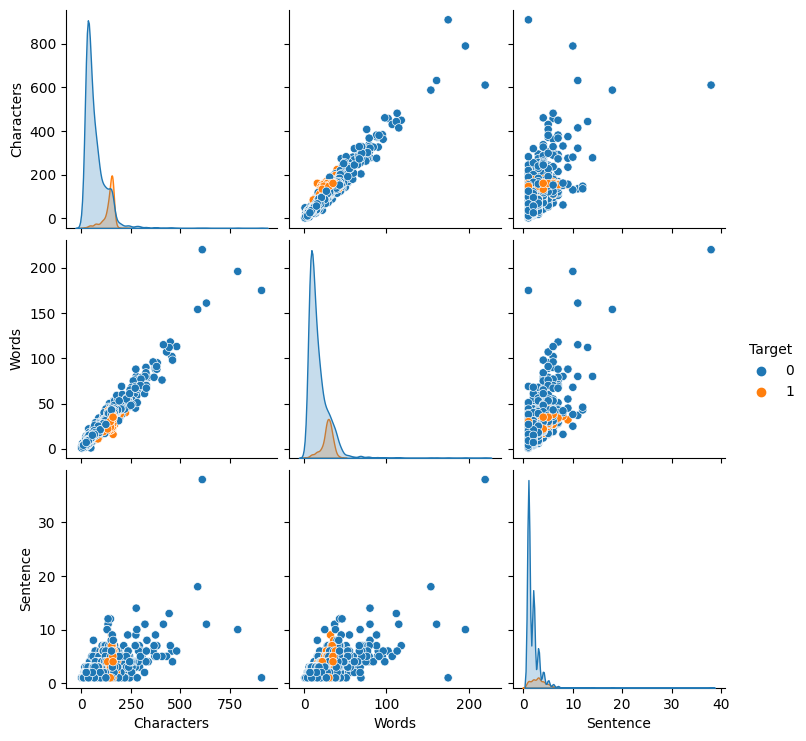

In [26]:
#Pairplot to get overall distribution of data
sns.pairplot(Email_spam, hue='Target')
plt.show()

Observation:
 - Outliers are present in data

In [27]:
Email_spam.corr()

,Target,Characters,Words,Sentence
Target,1.000000,0.384717,0.262912,0.263939
Characters,0.384717,1.000000,0.965760,0.624139
Words,0.262912,0.965760,1.000000,0.679971
Sentence,0.263939,0.624139,0.679971,1.000000


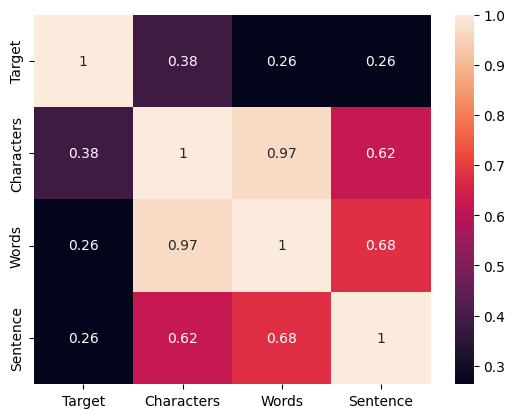

In [28]:
sns.heatmap(Email_spam.corr(), annot=True)
plt.show()

Observations:
 - 'Characters' and 'Words' have moderately strong positive correlation.

## 3. Data Preprocessing
Will perform following tasks:
 - Lower case
 - Tokenization
 - Removing special characters
 - Removing stopwords and puncuation
 - stemming

In [29]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [30]:
# transform_data()
transform_text(" Democracy, which was already on its deathbed, has also been murdered by these ruling elites, who colluded with undemocratic forces from within and outside to conduct this heinous act.")


'democraci alreadi deathb also murder rule elit collud undemocrat forc within outsid conduct heinou act'

In [31]:
Email_spam['Transformed_text'] = Email_spam['Text'].apply(transform_text)

In [32]:
Email_spam.sample(4)

,Target,Text,Characters,Words,Sentence,Transformed_text
3060,0,What u talking bout early morning? It's almost...,66,15,2,u talk bout earli morn almost noon
308,1,TheMob> Check out our newest selection of cont...,138,30,1,themob check newest select content game tone g...
4934,0,"Hey babe, how's it going ? Did you ever figure...",83,20,2,hey babe go ever figur go new year
944,0,I sent my scores to sophas and i had to do sec...,221,47,3,sent score sopha secondari applic school think...


In [33]:
# from wordcloud import WordCloud
# wc= WordCloud(width=500, height=500, min_font_size= 10, background_color=None)
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color=None)

In [34]:
#Wordcloud for SPAM
spam_wc = wc.generate(Email_spam[Email_spam['Target'] == 1]['Transformed_text'].str.cat(sep=" "))
# ham_wc = wc.generate(Email_spam[Email_spam['Target'] == 0]['Transformed_text'].str.cat(sep = " "))

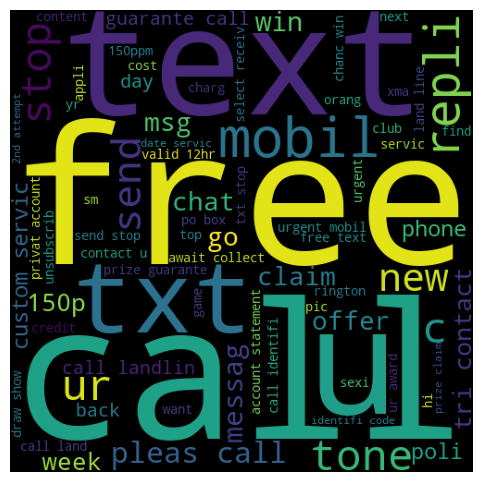

In [35]:
# # #SPAM
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)
plt.axis('off')
plt.show()


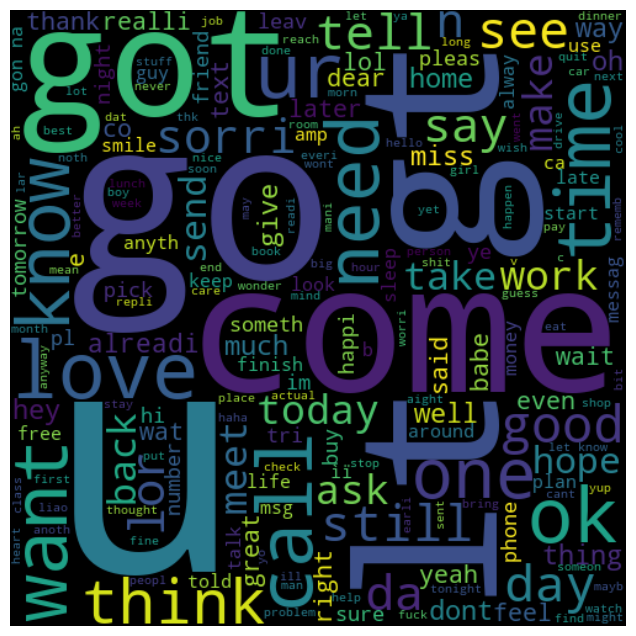

In [36]:
# #HAM
# ham_wc = wc.generate(Email_spam[Email_spam['Target'] == 0]['Transformed_text'].str.cat(sep= " "))
# ham_wc = wc.generate(Email_spam[Email_spam['Target'] == 0]['Transformed_text'].str.cat(sep = " "))
# ham_wc = wc.generate(Email_spam[Email_spam['Target'] == 0]['Transformed_text'].str.cat(sep = " "))
ham_wc = wc.generate(Email_spam[Email_spam['Target'] == 0]['Transformed_text'].str.cat(sep = " "))
plt.figure(figsize=(10,8))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
# #splitting SPAM sentences into words
spam_corpus = []
for msg in Email_spam[Email_spam['Target'] == 1]['Transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

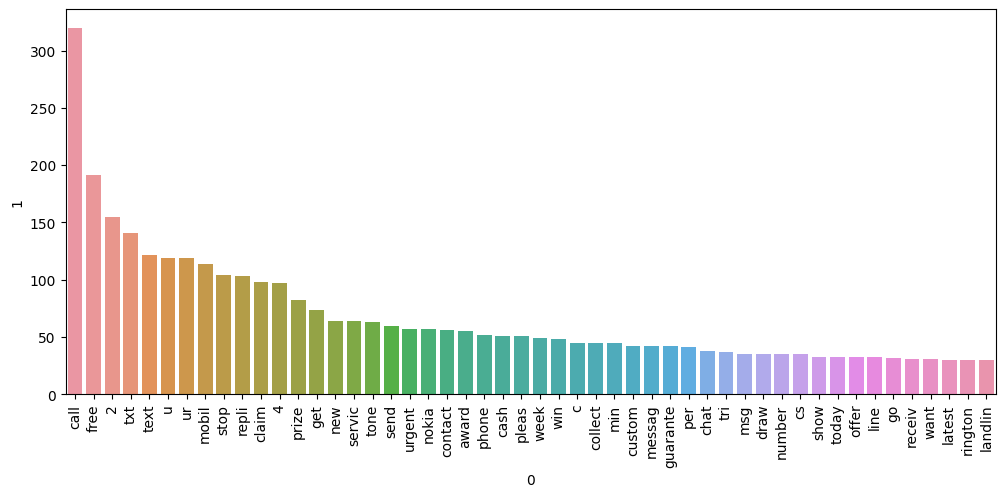

In [38]:
#Top 50 SPAM words
a = pd.DataFrame(Counter(spam_corpus).most_common(50))[0]
b= pd.DataFrame(Counter(spam_corpus).most_common(50))[1]
plt.figure(figsize=(12,5))
sns.barplot(x= a, y= b)
plt.xticks(rotation = 90)
plt.show()
# Email_spam

In [39]:
#Splitng HAM sentences into words

ham_corpus = []
for msg in Email_spam[Email_spam['Target'] == 0]['Transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)


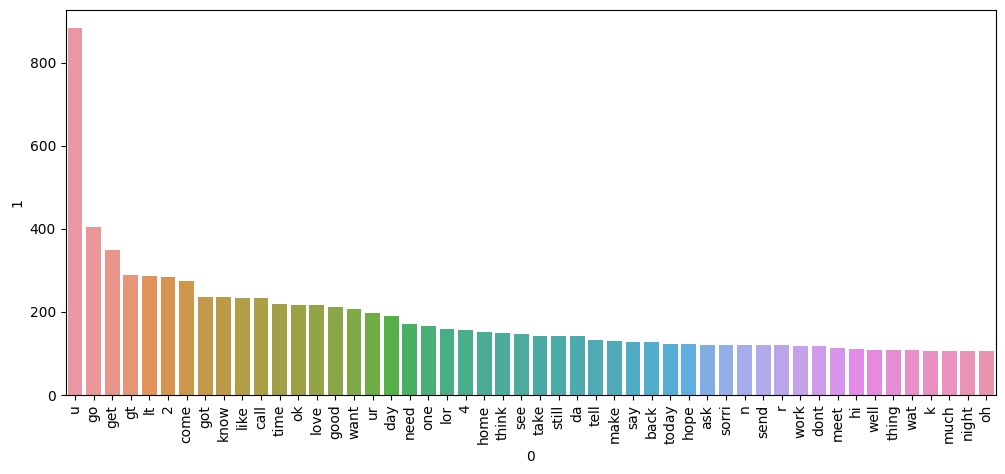

In [40]:
# Top 50 HAM Words
a = pd.DataFrame(Counter(ham_corpus).most_common(50))[0]
b = pd.DataFrame(Counter(ham_corpus).most_common(50))[1]
plt.figure(figsize=(12, 5))
sns.barplot(x= a, y =b)
plt.xticks(rotation = 90)
plt.show()

## Vectorization

In [41]:
# Initilizing TFIDF Vectorizer
tfidv = TfidfVectorizer(max_features=3000)

In [42]:
# Independent Feature
X = tfidv.fit_transform(Email_spam["Transformed_text"]).toarray()
# X = tfidv.fit_transform(Email_spam['Transformed_text'].toarray())

In [43]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Dependent Feature
y = Email_spam["Target"].values
y.shape

(5169,)

In [45]:
# Performing Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## 

In [46]:
# # import numpy as np
# # from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_selection import SelectKBest, chi2
# # from sklearn.model_selection import train_test_split
# # from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import classification_report, accuracy_score

# # Assuming you have your DataFrame with 'Transformed_text' and 'Target' columns
# X = Email_spam['Transformed_text']
# y = Email_spam['Target']

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert text to TF-IDF vectors
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Perform feature selection using SelectKBest and chi-squared test
# num_features = 1000  # Choose the number of top features you want to select
# selector = SelectKBest(chi2, k=num_features)
# X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
# X_test_selected = selector.transform(X_test_tfidf)

# # Train a classifier (Naive Bayes in this example)
# classifier = MultinomialNB()
# classifier.fit(X_train_selected, y_train)

# # Predict and evaluate
# y_pred = classifier.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Classification Report:\n{report}")


## Confusion Matrix
 - Will calculate conusion matrix using different algorithms of naive bayes.

In [47]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [48]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8694390715667312
[[788 108]
 [ 27 111]]
0.5068493150684932


In [49]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [50]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


## Models Training

In [51]:
# Models that are going to be trained
models={
    "Gaussian NB" : GaussianNB(),
    "Multinomial NB" : MultinomialNB(),
    "Bernoulli NB" : BernoulliNB(),
    "Logistic Regression" : LogisticRegression(),
    "SVC" : SVC(),
    "Decision Tree" : DecisionTreeClassifier(),
    "KNN" : KNeighborsClassifier(),
    "Bagging CLF" : BaggingClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "ETC" : ExtraTreesClassifier(),
    "Ada Boost" : AdaBoostClassifier(),
    "Gradient Boost" : GradientBoostingClassifier(),
    "XGB" : XGBClassifier(),
    "XGBRF" : XGBRFClassifier()
}

In [52]:
def train_clf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc= accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    
    return acc, pre

In [53]:
# A FOR loop Calls "traim_clf" for each model and stores accuracy and precision

acc_s = []
pre_s = []

for name, model in models.items():
    accuracy, precision = train_clf(model, X_train, y_train, X_test, y_test)
    
    acc_s.append(accuracy)
    pre_s.append(precision)

In [54]:
# # As Precision matter over Accuracy in our current problem, Sorting in DESC order of Precision.

# As Precision matter over Accuracy in this Data, Sorting in DESC order of Precision. All Scores of Models

scores_df = pd.DataFrame({"Algorithm": models.keys(), 
                          "Accuracy": acc_s, 
                         "Precision": pre_s}).sort_values(by="Precision", ascending=False)


In [55]:
scores_df

,Algorithm,Accuracy,Precision
1,Multinomial NB,0.970986,1.000000
6,KNN,0.905222,1.000000
2,Bernoulli NB,0.983559,0.991870
8,Random Forest,0.977756,0.983193
4,SVC,0.972921,0.982456
3,Logistic Regression,0.956480,0.979381
9,ETC,0.977756,0.975207
10,Ada Boost,0.961315,0.945455
12,XGB,0.971954,0.936000
11,Gradient Boost,0.953578,0.924528


In [56]:
#  Email_spam['Target'].value_counts()

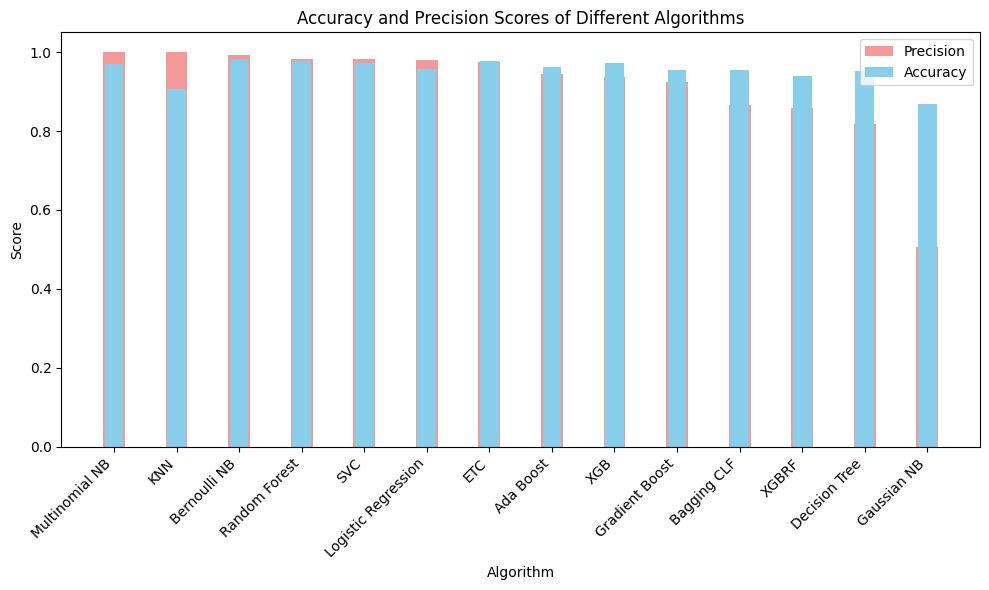

In [57]:
# # Graph Accuracy and Precision

# plt.figure(figsize=(10, 6))
# bar_width = 0.35

# plt.bar(scores_df["Algorithm"], scores_df["Precision"], width=bar_width, label="Precision", color='lightcoral', alpha=0.8)
# plt.bar(scores_df["Algorithm"], scores_df["Accuracy"], width=bar_width, label="Accuracy", color='skyblue')
# plt.xlabel("Algorithm")
# plt.ylabel("Score")
# plt.title("Accuracy and Precision Scores of Different Algorithms")
# plt.xticks(rotation=45, ha='right')
# plt.legend()
# plt.tight_layout()
# plt.show()
plt.figure(figsize=(10,6))
plt.bar(scores_df['Algorithm'], scores_df['Precision'], width=0.35, label = 'Precision', color= 'lightcoral', alpha = 0.8)
plt.bar(scores_df["Algorithm"], scores_df['Accuracy'], width= 0.3, label = 'Accuracy', color = 'skyblue')
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Accuracy and Precision Scores of Different Algorithms")
plt.xticks(rotation = 45, ha= 'right')
plt.legend()
plt.tight_layout()
plt.show()

## Observations:

 - Models with high precision scores, such as Multinomial NB, KNN, and Bernoulli NB, have a high ability to correctly identify positive instances.
 - Models with high accuracy scores, such as Bernoulli NB (98.16%) and Random Forest (97.49%), make accurate overall predictions on the dataset.

In [58]:
# # Hence Multinomial Naïve Bayes give excellent precision and accuracy scores.
# # According to me MNB is sutaible for Model

mnb=MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

## Pickle Files

In [59]:
# Pickle files help in Model Deployment

pickle.dump(mnb,open("model.pkl","wb"))
pickle.dump(tfidv, open("tfidf.pkl","wb"))

In [60]:
# to use these files later:
import pickle

loaded_model = pickle.load(open("model.pkl", "rb"))
loaded_tfidf = pickle.load(open("tfidf.pkl", "rb"))

In [61]:
import pickle

loaded_tfidf = pickle.load(open("tfidf.pkl", "rb"))